In [4]:
import os

os.chdir("../")

os.getcwd()

'/home/pk/Desktop/Project/deepCNNClassifier'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_image_size: list

@dataclass(frozen=True)
class PrepareCallbacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    checkpoint_model_filepath: Path

In [4]:
from deepClassifier.constants import *
from deepClassifier.utils import create_directories, read_yaml

In [5]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])

    def get_prepare_callback_config(self) -> PrepareCallbacksConfig:
        config = self.config.prepare_callbacks
        model_ckpt_dir = os.path.dirname(config.checkpoint_model_filepath)
        create_directories([
            Path(model_ckpt_dir),
            Path(config.tensorboard_root_log_dir)
        ])

        prepare_callback_config = PrepareCallbacksConfig(
            root_dir=Path(config.root_dir),
            tensorboard_root_log_dir=Path(config.tensorboard_root_log_dir),
            checkpoint_model_filepath=Path(config.checkpoint_model_filepath)
        )

        return prepare_callback_config

    def get_training_config(self) -> TrainingConfig:
        training = self.config.training
        prepare_base_model = self.config.prepare_base_model
        params = self.params
        training_data = os.path.join(self.config.data_ingestion.unzip_dir, "PetImages")
        create_directories([
            Path(training.root_dir)
        ])

        training_config = TrainingConfig(
            root_dir=Path(training.root_dir),
            trained_model_path=Path(training.trained_model_path),
            updated_base_model_path=Path(prepare_base_model.updated_base_model_path),
            training_data=Path(training_data),
            params_epochs=params.EPOCHS,
            params_batch_size=params.BATCH_SIZE,
            params_is_augmentation=params.AUGMENTATION,
            params_image_size=params.IMAGE_SIZE
        )

        return training_config

In [6]:
import os
import urllib.request as request
from zipfile import ZipFile

import tensorflow as tf

2022-09-22 14:46:54.848848: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-22 14:46:54.955297: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-22 14:46:55.284263: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/pk/miniconda3/lib/:/home/pk/miniconda3/lib/:/home/pk/Desktop/Project/deepCNNClassifier/env/lib/
2022-09-22 14:46:55.284306: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could no

In [7]:
import time

class PrepareCallback:
    def __init__(self, config: PrepareCallbacksConfig):
        self.config = config

    @property
    def _create_tb_callbacks(self):
        timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")
        tb_running_log_dir = os.path.join(
            self.config.tensorboard_root_log_dir,
            f"tb_logs_at_{timestamp}",
        )
        return tf.keras.callbacks.TensorBoard(log_dir=tb_running_log_dir)

    @property
    def _create_ckpt_callbacks(self):
        return tf.keras.callbacks.ModelCheckpoint(
            filepath=self.config.checkpoint_model_filepath,
            save_best_only=True
        )

    def get_tb_ckpt_callbacks(self):
        return [
            self._create_tb_callbacks,
            self._create_ckpt_callbacks
        ]

In [8]:
import os
import urllib.request as request
from zipfile import ZipFile
import tensorflow as tf
import time

class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config

    def get_base_model(self):
        self.model = tf.keras.models.load_model(
            self.config.updated_base_model_path
        )

    def train_valid_generator(self):

        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split=0.20
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            interpolation="bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )

        if self.config.params_is_augmentation:
            train_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=40,
                horizontal_flip=True,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                **datagenerator_kwargs
            )
        else:
            train_datagenerator = valid_datagenerator

        self.train_generator = train_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="training",
            shuffle=True,
            **dataflow_kwargs
        )

    @staticmethod
    def save_model(path: Path, model: tf.keras.Model):
        model.save(path)


    def train(self, callback_list: list):
        self.steps_per_epoch = self.train_generator.samples // self.train_generator.batch_size
        self.validation_steps = self.valid_generator.samples // self.valid_generator.batch_size

        self.model.fit(
            self.train_generator,
            epochs=self.config.params_epochs,
            steps_per_epoch=self.steps_per_epoch,
            validation_steps=self.validation_steps,
            validation_data=self.valid_generator,
            callbacks=callback_list
        )

        self.save_model(
            path=self.config.trained_model_path,
            model=self.model)

In [9]:
try:
    config = ConfigurationManager()
    prepare_callbacks_config = config.get_prepare_callback_config()
    prepare_callbacks = PrepareCallback(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.get_tb_ckpt_callbacks()
    
    training_config = config.get_training_config()
    training = Training(config=training_config)
    training.get_base_model()
    training.train_valid_generator()
    training.train(
        callback_list=callback_list
    )
    
except Exception as e:
    raise e

2022-09-22 14:46:56.018 | INFO     | deepClassifier.utils.common:read_yaml:30 - yaml file: configs/config.yaml loaded successfully
2022-09-22 14:46:56.019 | INFO     | deepClassifier.utils.common:read_yaml:30 - yaml file: params.yaml loaded successfully
2022-09-22 14:46:56.020 | INFO     | deepClassifier.utils.common:create_directories:49 - created directory at: artifacts
2022-09-22 14:46:56.020 | INFO     | deepClassifier.utils.common:create_directories:49 - created directory at: artifacts/prepare_callbacks/checkpoint_dir
2022-09-22 14:46:56.020 | INFO     | deepClassifier.utils.common:create_directories:49 - created directory at: artifacts/prepare_callbacks/tensorboard_log_dir
2022-09-22 14:46:56.021 | INFO     | deepClassifier.utils.common:create_directories:49 - created directory at: artifacts/training
2022-09-22 14:46:56.599041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one N

Found 4998 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Epoch 1/50


2022-09-22 14:46:58.399767: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-09-22 14:46:58.859354: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-22 14:46:59.381432: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-22 14:46:59.381460: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-22 14:46:59.381464: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to al

   3/1250 [..............................] - ETA: 1:52 - loss: 13.0355 - accuracy: 0.5417

2022-09-22 14:47:02.448318: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 157s 122ms/step - loss: 6.1884 - accuracy: 0.6908 - val_loss: 1.7073 - val_accuracy: 0.8592
Epoch 2/50
1250/1250 [==============================] - 155s 124ms/step - loss: 3.0276 - accuracy: 0.7854 - val_loss: 1.0557 - val_accuracy: 0.9026
Epoch 3/50
1250/1250 [==============================] - 154s 123ms/step - loss: 2.6162 - accuracy: 0.8030 - val_loss: 4.6762 - val_accuracy: 0.7520
Epoch 4/50
1250/1250 [==============================] - 154s 123ms/step - loss: 2.3266 - accuracy: 0.8180 - val_loss: 1.3354 - val_accuracy: 0.8908
Epoch 5/50
1250/1250 [==============================] - 154s 123ms/step - loss: 2.1671 - accuracy: 0.8229 - val_loss: 1.3689 - val_accuracy: 0.8758
Epoch 6/50
1250/1250 [==============================] - 152s 122ms/step - loss: 2.1062 - accuracy: 0.8273 - val_loss: 0.7862 - val_accuracy: 0.9231
Epoch 7/50
1250/1250 [==============================] - 152s 121ms/step - loss: 2.0990 - accuracy: 0.8325 - val_loss: 0.733

In [1]:
import tensorflow as tf 

2022-09-22 16:56:28.925861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-22 16:56:29.024349: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-22 16:56:29.422585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/pk/miniconda3/lib/:/home/pk/miniconda3/lib/:/home/pk/Desktop/Project/deepCNNClassifier/env/lib/
2022-09-22 16:56:29.422632: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could no

In [5]:
model = tf.keras.models.load_model("artifacts/training/model.h5")

2022-09-22 16:56:48.242478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 16:56:48.245939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 16:56:48.246030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 16:56:48.246909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

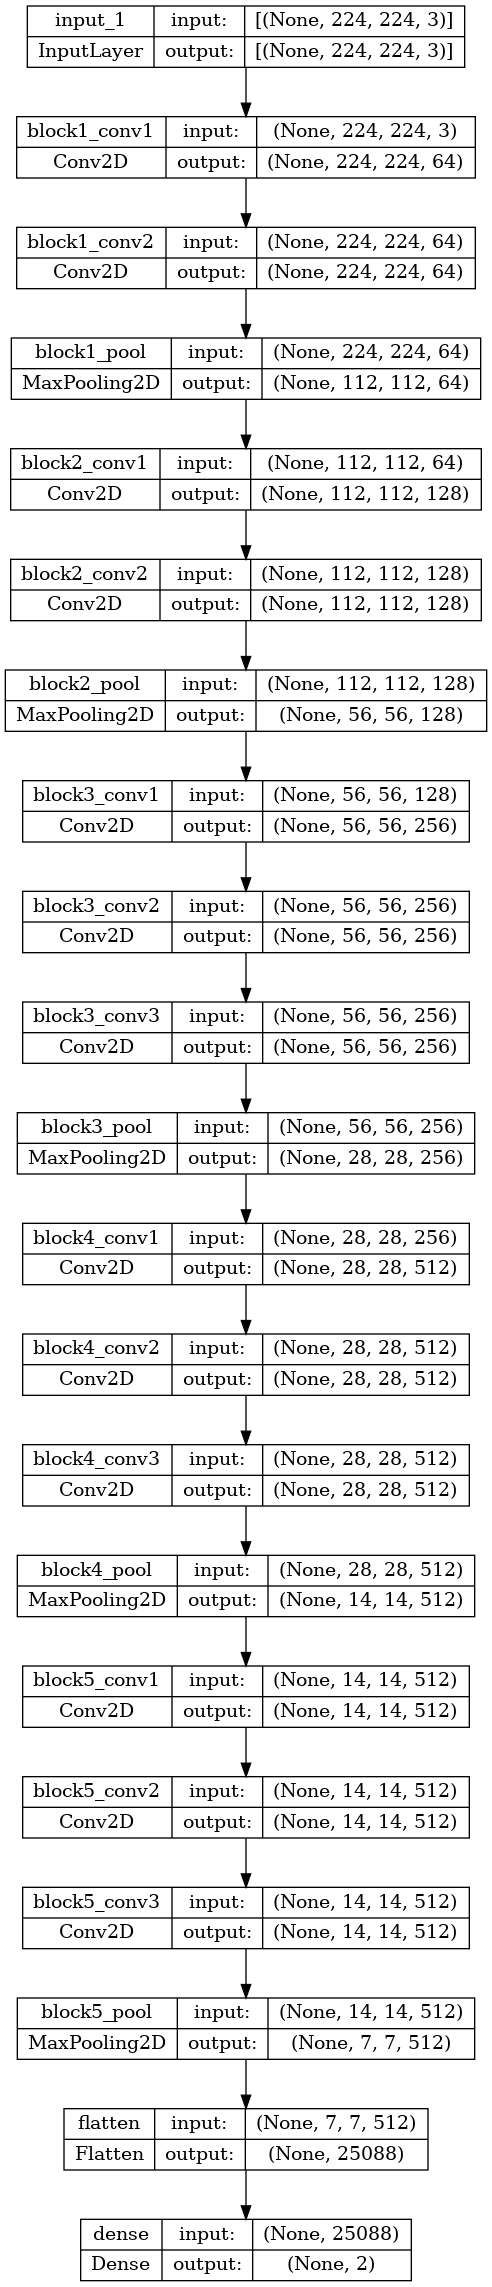

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)